In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import itertools # Pour créer des iterateurs

import matplotlib.pyplot as plt  # Pour l'affichage d'images
from matplotlib import cm # Pour importer de nouvelles cartes de couleur

from sklearn.model_selection import train_test_split
from sklearn import metrics

from PIL import Image

import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB1
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout, Conv2D, MaxPooling2D, BatchNormalization, LeakyReLU, Flatten
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras import callbacks

%matplotlib inline

# **Set the path names (csv + image folder)**

In [ ]:
csv_label0 = "/content/gdrive/MyDrive/Colab Notebooks/dataset_label0_Inocybaceae.csv"
csv_label1 = "/content/gdrive/MyDrive/Colab Notebooks/dataset_label1_Omphalotaceae.csv"
csv_label2 = "/content/gdrive/MyDrive/Colab Notebooks/dataset_label2_Fomitopsidaceae.csv"
csv_label3 = "/content/gdrive/MyDrive/Colab Notebooks/dataset_label3_Physalacriaceae.csv"
csv_label4 = "/content/gdrive/MyDrive/Colab Notebooks/dataset_label4_Marasmiaceae.csv"


folderpath = "/content/gdrive/MyDrive/images_mushroom/"

In [ ]:
df = pd.read_csv(csv_label2)
df['filepath'] = [folderpath + str(df['image_id'][x]) + ".jpg" for x in range(len(df))]
df.head()

,image_id,image_url,genus,family,filepath,label_family,label
0,202,http://mushroomobserver.org/images/320/202,Phaeolus,Fomitopsidaceae,/content/gdrive/MyDrive/images_mushroom/202.jpg,2,2
1,223,http://mushroomobserver.org/images/320/223,Postia,Fomitopsidaceae,/content/gdrive/MyDrive/images_mushroom/223.jpg,2,3
2,305,http://mushroomobserver.org/images/320/305,Laetiporus,Fomitopsidaceae,/content/gdrive/MyDrive/images_mushroom/305.jpg,2,1
3,307,http://mushroomobserver.org/images/320/307,Laetiporus,Fomitopsidaceae,/content/gdrive/MyDrive/images_mushroom/307.jpg,2,1
4,437,http://mushroomobserver.org/images/320/437,Fomitopsis,Fomitopsidaceae,/content/gdrive/MyDrive/images_mushroom/437.jpg,2,0


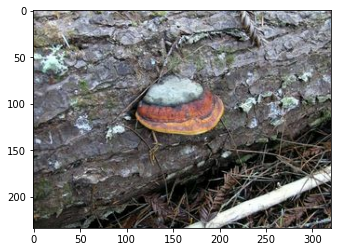

In [ ]:
# Just to run a simple test:

im = tf.io.read_file(df['filepath'].iloc[37])
# Décoder l'information en un tensorflow RGB (3 channels).
im = tf.image.decode_jpeg(im, channels=3)

plt.imshow(im);

# **Set the train/test datagenerators !**

In [ ]:
train_data_generator = ImageDataGenerator(rotation_range=5,
                                          width_shift_range = 0.1,
                                          height_shift_range = 0.05,
                                          zoom_range = 1.1,
                                          horizontal_flip = True,
                                          vertical_flip = True)

test_data_generator = ImageDataGenerator()

# **Modèle famille 1 --> label0**

In [ ]:
df = pd.read_csv(csv_label0)
df['filepath'] = [folderpath + str(df['image_id'][x]) + ".jpg" for x in range(len(df))]

display(df.head())

data_train, data_test = train_test_split(df, test_size=0.2, random_state=42)
data_train.head()

batch_size = 32

data_train["label"] = data_train["label"].astype(str)
data_test["label"] = data_test["label"].astype(str)

train_generator = train_data_generator.flow_from_dataframe(dataframe = data_train, directory="", x_col = "filepath", y_col="label", target_size=(256,256), batch_size=batch_size, class_mode='sparse')
test_generator = test_data_generator.flow_from_dataframe(dataframe = data_test, directory="", x_col = "filepath", y_col="label", target_size=(256,256), batch_size=batch_size, class_mode='sparse')

num_class = df["genus"].nunique()

efficientNet = EfficientNetB1(include_top=False, input_shape=(256, 256, 3))
for layer in efficientNet.layers[-1:]:
    layer.trainable = True

model = Sequential()
model.add(efficientNet)
model.add(GlobalAveragePooling2D())
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = num_class, activation = 'softmax'))

model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                         patience = 3,
                                         factor = 0.1,
                                         verbose = 2,
                                         mode = 'min')

early_stopping = callbacks.EarlyStopping(monitor = "val_loss",
                                         patience = 7,
                                         mode = 'min',
                                         verbose = 2,
                                         restore_best_weights= True)

checkpoint = callbacks.ModelCheckpoint(filepath="/content/gdrive/MyDrive/Colab Notebooks/modele_genus/checkpoint_genus_fam1/model_label0_effnetB1_temp_20210627.h5",
                                      monitor = 'val_loss',
                                      save_best_only = True,
                                      save_weights_only = False,
                                      mode = 'min',
                                      save_freq = 'epoch')


history = model.fit(train_generator, 
                              epochs = 40,
                              steps_per_epoch = len(data_train)//batch_size,
                              validation_data = test_generator,
                              validation_steps = len(data_test)//batch_size,
                              callbacks=[lr_plateau, early_stopping, checkpoint])

### Set the path and name you want !
##
#
save_name = "/content/gdrive/MyDrive/Colab Notebooks/modele_genus/model_label0_effnetB1_fin_20210627.h5"
save_name2 = "/content/gdrive/MyDrive/Colab Notebooks/modele_genus/model_label0_effnetB1_fin_weights_20210627.h5"
#
##
###

model.save(save_name)
model.save_weights(save_name2)

,image_id,image_url,genus,family,filepath,label_family,label
0,28,http://mushroomobserver.org/images/320/28,Inocybe,Inocybaceae,/content/gdrive/MyDrive/images_mushroom/28.jpg,0,0
1,330,http://mushroomobserver.org/images/320/330,Inocybe,Inocybaceae,/content/gdrive/MyDrive/images_mushroom/330.jpg,0,0
2,331,http://mushroomobserver.org/images/320/331,Inocybe,Inocybaceae,/content/gdrive/MyDrive/images_mushroom/331.jpg,0,0
3,332,http://mushroomobserver.org/images/320/332,Inocybe,Inocybaceae,/content/gdrive/MyDrive/images_mushroom/332.jpg,0,0
4,334,http://mushroomobserver.org/images/320/334,Inocybe,Inocybaceae,/content/gdrive/MyDrive/images_mushroom/334.jpg,0,0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Found 3058 validated image filenames belonging to 4 classes.
Found 765 validated image filenames belonging to 4 classes.
Epoch 1/40
95/95 [==============================] - 1029s 11s/step - loss: 0.6789 - accuracy: 0.7974 - val_loss: 0.5221 - val_accuracy: 0.8465


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/40
95/95 [==============================] - 62s 651ms/step - loss: 0.6046 - accuracy: 0.8116 - val_loss: 0.5511 - val_accuracy: 0.8519
Epoch 3/40
95/95 [==============================] - 62s 647ms/step - loss: 0.5348 - accuracy: 0.8334 - val_loss: 0.6951 - val_accuracy: 0.7527
Epoch 4/40
95/95 [==============================] - 62s 647ms/step - loss: 0.5259 - accuracy: 0.8377 - val_loss: 0.5545 - val_accuracy: 0.8587

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 5/40
95/95 [==============================] - 62s 652ms/step - loss: 0.4388 - accuracy: 0.8586 - val_loss: 0.3503 - val_accuracy: 0.9076
Epoch 6/40
95/95 [==============================] - 62s 650ms/step - loss: 0.4180 - accuracy: 0.8635 - val_loss: 0.3234 - val_accuracy: 0.9090
Epoch 7/40
95/95 [==============================] - 62s 650ms/step - loss: 0.3826 - accuracy: 0.8754 - val_loss: 0.2952 - val_accuracy: 0.9212
Epoch 8/40
95/95 [==============================] - 63s 659m

# **Modèle famille 2 --> label1**

In [ ]:
df = pd.read_csv(csv_label1)
df['filepath'] = [folderpath + str(df['image_id'][x]) + ".jpg" for x in range(len(df))]

display(df.head())

data_train, data_test = train_test_split(df, test_size=0.2, random_state=42)
data_train.head()

batch_size = 32

data_train["label"] = data_train["label"].astype(str)
data_test["label"] = data_test["label"].astype(str)

train_generator = train_data_generator.flow_from_dataframe(dataframe = data_train, directory="", x_col = "filepath", y_col="label", target_size=(256,256), batch_size=batch_size, class_mode='sparse')
test_generator = test_data_generator.flow_from_dataframe(dataframe = data_test, directory="", x_col = "filepath", y_col="label", target_size=(256,256), batch_size=batch_size, class_mode='sparse')

num_class = df["genus"].nunique()

efficientNet = EfficientNetB1(include_top=False, input_shape=(256, 256, 3))
for layer in efficientNet.layers[-1:]:
    layer.trainable = True

model = Sequential()
model.add(efficientNet)
model.add(GlobalAveragePooling2D())
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = num_class, activation = 'softmax'))

model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                         patience = 3,
                                         factor = 0.1,
                                         verbose = 2,
                                         mode = 'min')

early_stopping = callbacks.EarlyStopping(monitor = "val_loss",
                                         patience = 7,
                                         mode = 'min',
                                         verbose = 2,
                                         restore_best_weights= True)

checkpoint = callbacks.ModelCheckpoint(filepath="/content/gdrive/MyDrive/Colab Notebooks/modele_genus/checkpoint_genus_fam2/model_label1_effnetB1_temp_20210627.h5",
                                      monitor = 'val_loss',
                                      save_best_only = True,
                                      save_weights_only = False,
                                      mode = 'min',
                                      save_freq = 'epoch')


history = model.fit(train_generator, 
                              epochs = 40,
                              steps_per_epoch = len(data_train)//batch_size,
                              validation_data = test_generator,
                              validation_steps = len(data_test)//batch_size,
                              callbacks=[lr_plateau, early_stopping, checkpoint])

### Set the path and name you want !
##
#
save_name = "/content/gdrive/MyDrive/Colab Notebooks/modele_genus/model_label1_effnetB1_fin_20210627.h5"
save_name2 = "/content/gdrive/MyDrive/Colab Notebooks/modele_genus/model_label1_effnetB1_fin_weights_20210627.h5"
#
##
###

model.save(save_name)
model.save_weights(save_name2)

,image_id,image_url,genus,family,filepath,label_family,label
0,126,http://mushroomobserver.org/images/320/126,Rhodocollybia,Omphalotaceae,/content/gdrive/MyDrive/images_mushroom/126.jpg,1,2
1,128,http://mushroomobserver.org/images/320/128,Rhodocollybia,Omphalotaceae,/content/gdrive/MyDrive/images_mushroom/128.jpg,1,2
2,218,http://mushroomobserver.org/images/320/218,Omphalotus,Omphalotaceae,/content/gdrive/MyDrive/images_mushroom/218.jpg,1,1
3,220,http://mushroomobserver.org/images/320/220,Omphalotus,Omphalotaceae,/content/gdrive/MyDrive/images_mushroom/220.jpg,1,1
4,221,http://mushroomobserver.org/images/320/221,Omphalotus,Omphalotaceae,/content/gdrive/MyDrive/images_mushroom/221.jpg,1,1


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Found 2786 validated image filenames belonging to 4 classes.
Found 697 validated image filenames belonging to 4 classes.
Epoch 1/40
87/87 [==============================] - 927s 11s/step - loss: 0.9004 - accuracy: 0.6736 - val_loss: 0.7268 - val_accuracy: 0.7530


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/40
87/87 [==============================] - 57s 651ms/step - loss: 0.7483 - accuracy: 0.7197 - val_loss: 0.6914 - val_accuracy: 0.7247
Epoch 3/40
87/87 [==============================] - 57s 650ms/step - loss: 0.6963 - accuracy: 0.7415 - val_loss: 0.6171 - val_accuracy: 0.7753
Epoch 4/40
87/87 [==============================] - 57s 655ms/step - loss: 0.7315 - accuracy: 0.7262 - val_loss: 0.7201 - val_accuracy: 0.7842
Epoch 5/40
87/87 [==============================] - 57s 652ms/step - loss: 0.6795 - accuracy: 0.7545 - val_loss: 0.7251 - val_accuracy: 0.7827
Epoch 6/40
87/87 [==============================] - 57s 651ms/step - loss: 0.6433 - accuracy: 0.7680 - val_loss: 0.7682 - val_accuracy: 0.6548

Epoch 00006: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 7/40
87/87 [==============================] - 57s 650ms/step - loss: 0.5796 - accuracy: 0.7800 - val_loss: 0.4578 - val_accuracy: 0.8259
Epoch 8/40
87/87 [==============================] - 57s 653m

# **Modèle famille 3 --> label2**

In [ ]:
df = pd.read_csv(csv_label2)
df['filepath'] = [folderpath + str(df['image_id'][x]) + ".jpg" for x in range(len(df))]
display(df.head())

data_train, data_test = train_test_split(df, test_size=0.2, random_state=42)
#data_train.head()

batch_size = 32

data_train["label"] = data_train["label"].astype(str)
data_test["label"] = data_test["label"].astype(str)

train_generator = train_data_generator.flow_from_dataframe(dataframe = data_train, directory="", x_col = "filepath", y_col="label", target_size=(256,256), batch_size=batch_size, class_mode='sparse')
test_generator = test_data_generator.flow_from_dataframe(dataframe = data_test, directory="", x_col = "filepath", y_col="label", target_size=(256,256), batch_size=batch_size, class_mode='sparse')

num_class = df["genus"].nunique()

efficientNet = EfficientNetB1(include_top=False, input_shape=(256, 256, 3))
for layer in efficientNet.layers[-1:]:
    layer.trainable = True

model = Sequential()
model.add(efficientNet)
model.add(GlobalAveragePooling2D())
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = num_class, activation = 'softmax'))

model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                         patience = 3,
                                         factor = 0.1,
                                         verbose = 2,
                                         mode = 'min')

early_stopping = callbacks.EarlyStopping(monitor = "val_loss",
                                         patience = 7,
                                         mode = 'min',
                                         verbose = 2,
                                         restore_best_weights= True)

checkpoint = callbacks.ModelCheckpoint(filepath="/content/gdrive/MyDrive/Colab Notebooks/modele_genus/checkpoint_genus_fam3/model_label2_effnetB1_temp_20210627.h5",
                                      monitor = 'val_loss',
                                      save_best_only = True,
                                      save_weights_only = False,
                                      mode = 'min',
                                      save_freq = 'epoch')


history = model.fit(train_generator, 
                              epochs = 40,
                              steps_per_epoch = len(data_train)//batch_size,
                              validation_data = test_generator,
                              validation_steps = len(data_test)//batch_size,
                              callbacks=[lr_plateau, early_stopping, checkpoint])

### Set the path and name you want !
##
#
save_name = "/content/gdrive/MyDrive/Colab Notebooks/modele_genus/model_label2_effnetB1_fin_20210627.h5"
save_name2 = "/content/gdrive/MyDrive/Colab Notebooks/modele_genus/model_label2_effnetB1_fin_weights_20210627.h5"
#
##
###

model.save(save_name)
model.save_weights(save_name2)

,image_id,image_url,genus,family,filepath,label_family,label
0,202,http://mushroomobserver.org/images/320/202,Phaeolus,Fomitopsidaceae,/content/gdrive/MyDrive/images_mushroom/202.jpg,2,2
1,223,http://mushroomobserver.org/images/320/223,Postia,Fomitopsidaceae,/content/gdrive/MyDrive/images_mushroom/223.jpg,2,3
2,305,http://mushroomobserver.org/images/320/305,Laetiporus,Fomitopsidaceae,/content/gdrive/MyDrive/images_mushroom/305.jpg,2,1
3,307,http://mushroomobserver.org/images/320/307,Laetiporus,Fomitopsidaceae,/content/gdrive/MyDrive/images_mushroom/307.jpg,2,1
4,437,http://mushroomobserver.org/images/320/437,Fomitopsis,Fomitopsidaceae,/content/gdrive/MyDrive/images_mushroom/437.jpg,2,0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Found 2404 validated image filenames belonging to 8 classes.
Found 602 validated image filenames belonging to 8 classes.
Epoch 1/40
75/75 [==============================] - 76s 881ms/step - loss: 1.5383 - accuracy: 0.4713 - val_loss: 1.5818 - val_accuracy: 0.5816


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/40
75/75 [==============================] - 49s 654ms/step - loss: 1.3153 - accuracy: 0.5573 - val_loss: 1.0452 - val_accuracy: 0.6580
Epoch 3/40
75/75 [==============================] - 49s 651ms/step - loss: 1.1988 - accuracy: 0.5982 - val_loss: 1.7466 - val_accuracy: 0.4740
Epoch 4/40
75/75 [==============================] - 49s 650ms/step - loss: 1.1659 - accuracy: 0.6096 - val_loss: 1.3157 - val_accuracy: 0.6302
Epoch 5/40
75/75 [==============================] - 49s 649ms/step - loss: 1.0735 - accuracy: 0.6391 - val_loss: 1.0679 - val_accuracy: 0.6788

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/40
75/75 [==============================] - 49s 653ms/step - loss: 0.9085 - accuracy: 0.6986 - val_loss: 0.7530 - val_accuracy: 0.7483
Epoch 7/40
75/75 [==============================] - 49s 650ms/step - loss: 0.8730 - accuracy: 0.6986 - val_loss: 0.6749 - val_accuracy: 0.7847
Epoch 8/40
75/75 [==============================] - 49s 650m

# **Modèle famille 4 --> label3**

In [ ]:
df = pd.read_csv(csv_label3)

df['filepath'] = [folderpath + str(df['image_id'][x]) + ".jpg" for x in range(len(df))]

display(df.head())

data_train, data_test = train_test_split(df, test_size=0.2, random_state=42)
data_train.head()

batch_size = 32

data_train["label"] = data_train["label"].astype(str)
data_test["label"] = data_test["label"].astype(str)

train_generator = train_data_generator.flow_from_dataframe(dataframe = data_train, directory="", x_col = "filepath", y_col="label", target_size=(256,256), batch_size=batch_size, class_mode='sparse')
test_generator = test_data_generator.flow_from_dataframe(dataframe = data_test, directory="", x_col = "filepath", y_col="label", target_size=(256,256), batch_size=batch_size, class_mode='sparse')

num_class = df["genus"].nunique()

efficientNet = EfficientNetB1(include_top=False, input_shape=(256, 256, 3))
for layer in efficientNet.layers[-1:]:
    layer.trainable = True

model = Sequential()
model.add(efficientNet)
model.add(GlobalAveragePooling2D())
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = num_class, activation = 'softmax'))

model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                         patience = 3,
                                         factor = 0.1,
                                         verbose = 2,
                                         mode = 'min')

early_stopping = callbacks.EarlyStopping(monitor = "val_loss",
                                         patience = 7,
                                         mode = 'min',
                                         verbose = 2,
                                         restore_best_weights= True)

checkpoint = callbacks.ModelCheckpoint(filepath="/content/gdrive/MyDrive/Colab Notebooks/modele_genus/checkpoint_genus_fam4/model_label3_effnetB1_temp_20210627.h5",
                                      monitor = 'val_loss',
                                      save_best_only = True,
                                      save_weights_only = False,
                                      mode = 'min',
                                      save_freq = 'epoch')


history = model.fit(train_generator, 
                              epochs = 40,
                              steps_per_epoch = len(data_train)//batch_size,
                              validation_data = test_generator,
                              validation_steps = len(data_test)//batch_size,
                              callbacks=[lr_plateau, early_stopping, checkpoint])

### Set the path and name you want !
##
#
save_name = "/content/gdrive/MyDrive/Colab Notebooks/modele_genus/model_label3_effnetB1_fin_20210627.h5"
save_name2 = "/content/gdrive/MyDrive/Colab Notebooks/modele_genus/model_label3_effnetB1_fin_weights_20210627.h5"
#
##
###

model.save(save_name)
model.save_weights(save_name2)

,image_id,image_url,genus,family,filepath,label_family,label
0,86,http://mushroomobserver.org/images/320/86,Strobilurus,Physalacriaceae,/content/gdrive/MyDrive/images_mushroom/86.jpg,3,3
1,87,http://mushroomobserver.org/images/320/87,Strobilurus,Physalacriaceae,/content/gdrive/MyDrive/images_mushroom/87.jpg,3,3
2,441,http://mushroomobserver.org/images/320/441,Flammulina,Physalacriaceae,/content/gdrive/MyDrive/images_mushroom/441.jpg,3,2
3,611,http://mushroomobserver.org/images/320/611,Armillaria,Physalacriaceae,/content/gdrive/MyDrive/images_mushroom/611.jpg,3,0
4,613,http://mushroomobserver.org/images/320/613,Armillaria,Physalacriaceae,/content/gdrive/MyDrive/images_mushroom/613.jpg,3,0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


Found 2298 validated image filenames belonging to 6 classes.
Found 575 validated image filenames belonging to 6 classes.
Epoch 1/40
71/71 [==============================] - 777s 11s/step - loss: 1.0988 - accuracy: 0.6236 - val_loss: 0.8768 - val_accuracy: 0.7151


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/40
71/71 [==============================] - 46s 642ms/step - loss: 0.8635 - accuracy: 0.7061 - val_loss: 0.6974 - val_accuracy: 0.7629
Epoch 3/40
71/71 [==============================] - 46s 640ms/step - loss: 0.7804 - accuracy: 0.7387 - val_loss: 1.3986 - val_accuracy: 0.6544
Epoch 4/40
71/71 [==============================] - 46s 641ms/step - loss: 0.7885 - accuracy: 0.7365 - val_loss: 0.8357 - val_accuracy: 0.7371
Epoch 5/40
71/71 [==============================] - 46s 638ms/step - loss: 0.7473 - accuracy: 0.7449 - val_loss: 0.6992 - val_accuracy: 0.7390

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Epoch 6/40
71/71 [==============================] - 46s 639ms/step - loss: 0.5675 - accuracy: 0.8023 - val_loss: 0.4538 - val_accuracy: 0.8474
Epoch 7/40
71/71 [==============================] - 46s 644ms/step - loss: 0.5377 - accuracy: 0.8204 - val_loss: 0.4323 - val_accuracy: 0.8511
Epoch 8/40
71/71 [==============================] - 46s 644m

# **Modèle famille 5 --> label4**

In [ ]:
df = pd.read_csv(csv_label4)
df['filepath'] = [folderpath + str(df['image_id'][x]) + ".jpg" for x in range(len(df))]

display(df.head())

data_train, data_test = train_test_split(df, test_size=0.2, random_state=42)
data_train.head()

batch_size = 32

data_train["label"] = data_train["label"].astype(str)
data_test["label"] = data_test["label"].astype(str)

train_generator = train_data_generator.flow_from_dataframe(dataframe = data_train, directory="", x_col = "filepath", y_col="label", target_size=(256,256), batch_size=batch_size, class_mode='sparse')
test_generator = test_data_generator.flow_from_dataframe(dataframe = data_test, directory="", x_col = "filepath", y_col="label", target_size=(256,256), batch_size=batch_size, class_mode='sparse')

num_class = df["genus"].nunique()

efficientNet = EfficientNetB1(include_top=False, input_shape=(256, 256, 3))
for layer in efficientNet.layers[-1:]:
    layer.trainable = True

model = Sequential()
model.add(efficientNet)
model.add(GlobalAveragePooling2D())
model.add(Dense(units = 1024, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = num_class, activation = 'softmax'))

model.compile(optimizer = 'Adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

lr_plateau = callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                         patience = 3,
                                         factor = 0.1,
                                         verbose = 2,
                                         mode = 'min')

early_stopping = callbacks.EarlyStopping(monitor = "val_loss",
                                         patience = 7,
                                         mode = 'min',
                                         verbose = 2,
                                         restore_best_weights= True)

checkpoint = callbacks.ModelCheckpoint(filepath="/content/gdrive/MyDrive/Colab Notebooks/modele_genus/checkpoint_genus_fam5/model_label4_effnetB1_temp_20210627.h5",
                                      monitor = 'val_loss',
                                      save_best_only = True,
                                      save_weights_only = False,
                                      mode = 'min',
                                      save_freq = 'epoch')


history = model.fit(train_generator, 
                              epochs = 40,
                              steps_per_epoch = len(data_train)//batch_size,
                              validation_data = test_generator,
                              validation_steps = len(data_test)//batch_size,
                              callbacks=[lr_plateau, early_stopping, checkpoint])

### Set the path and name you want !
##
#
save_name = "/content/gdrive/MyDrive/Colab Notebooks/modele_genus/model_label4_effnetB1_fin_20210627.h5"
save_name2 = "/content/gdrive/MyDrive/Colab Notebooks/modele_genus/model_label4_effnetB1_fin_weights_20210627.h5"
#
##
###

model.save(save_name)
model.save_weights(save_name2)

,image_id,image_url,genus,family,filepath,label_family,label
0,241,http://mushroomobserver.org/images/320/241,Atheniella,Marasmiaceae,/content/gdrive/MyDrive/images_mushroom/241.jpg,4,4
1,262,http://mushroomobserver.org/images/320/262,Marasmius,Marasmiaceae,/content/gdrive/MyDrive/images_mushroom/262.jpg,4,0
2,264,http://mushroomobserver.org/images/320/264,Marasmius,Marasmiaceae,/content/gdrive/MyDrive/images_mushroom/264.jpg,4,0
3,265,http://mushroomobserver.org/images/320/265,Marasmius,Marasmiaceae,/content/gdrive/MyDrive/images_mushroom/265.jpg,4,0
4,266,http://mushroomobserver.org/images/320/266,Marasmius,Marasmiaceae,/content/gdrive/MyDrive/images_mushroom/266.jpg,4,0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


Found 2056 validated image filenames belonging to 6 classes.
Found 514 validated image filenames belonging to 6 classes.
Epoch 1/40
64/64 [==============================] - 708s 11s/step - loss: 1.0667 - accuracy: 0.6729 - val_loss: 1.0010 - val_accuracy: 0.7969


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/40
64/64 [==============================] - 43s 661ms/step - loss: 0.8952 - accuracy: 0.7213 - val_loss: 1.2045 - val_accuracy: 0.6406
Epoch 3/40
64/64 [==============================] - 42s 652ms/step - loss: 0.8176 - accuracy: 0.7292 - val_loss: 1.1355 - val_accuracy: 0.6465
Epoch 4/40
64/64 [==============================] - 42s 647ms/step - loss: 0.7965 - accuracy: 0.7342 - val_loss: 0.6723 - val_accuracy: 0.8066
Epoch 5/40
64/64 [==============================] - 43s 661ms/step - loss: 0.7101 - accuracy: 0.7722 - val_loss: 0.8398 - val_accuracy: 0.7715
Epoch 6/40
64/64 [==============================] - 43s 661ms/step - loss: 0.6946 - accuracy: 0.7663 - val_loss: 0.6036 - val_accuracy: 0.8086
Epoch 7/40
64/64 [==============================] - 42s 644ms/step - loss: 0.6689 - accuracy: 0.7821 - val_loss: 0.6287 - val_accuracy: 0.7891
Epoch 8/40
64/64 [==============================] - 42s 652ms/step - loss: 0.6771 - accuracy: 0.7861 - val_loss: 0.5692 - val_accuracy: 0.8418